In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.optim import Adam
import torch
from torchtune.datasets import ConcatDataset
import optuna
import lightning.pytorch as pl
from electricity_price_forecast.data.dataset import DatasetWithWindow
from electricity_price_forecast.model.lstm_model import LSTMModel
from electricity_price_forecast.model.torch_lightning_module import TorchLightningModule
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from electricity_price_forecast.data.datamodule import Datamodule
from electricity_price_forecast.data.data_visualization import plot_prices, plot_predictions_vs_real
import logging
from electricity_price_forecast.model.lstm_model import MULTI_STEP
from electricity_price_forecast.data.data_processing import transform_synthetic_data_optimized, preprocess_true_data, preprocess_synthetic_data, DataNormalizer, get_predict_data, get_splits

logging.getLogger("lightning.pytorch").setLevel(logging.WARNING)

VAL_RATIO = 0.2
TESTED_HORIZONS = [6, 12, 24, 48, 72, 168]

import error: No module named 'triton'


d:\Programs\Anaconda\envs\air_liquide_ai_challenge\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_price = pd.read_parquet("../data/donnees historiques/prix/hourly_day_ahead_prices_2017_2020.parquet")
df_price_generated_00257 = pd.read_parquet("../data/scenarios synthetiques/prix/00257.parquet")

print(df_price.index.min())
print(df_price.index.max())
df_price.head()

2016-12-31 23:00:00+00:00
2020-12-31 22:00:00+00:00


,price
date,
2016-12-31 23:00:00+00:00,58.82
2017-01-01 00:00:00+00:00,58.23
2017-01-01 01:00:00+00:00,51.95
2017-01-01 02:00:00+00:00,47.27
2017-01-01 03:00:00+00:00,45.49


In [3]:
print(df_price_generated_00257["dayofweek"].min())
print(df_price_generated_00257["dayofweek"].max())
df_price_generated_00257.head()

0
6


,price,dayofweek,hourofday
0,31.66,0,0
1,31.06,0,1
2,27.81,0,2
3,27.54,0,3
4,25.04,0,4


## Preprocess data

In [4]:
df_price_preprocessed = preprocess_true_data(df_price)
df_price_preprocessed.head()

,price,dayofweek,hourofday,dayofyear,dayofseries,dayofmonth,month,year,hourofseries
date,,,,,,,,,
2016-12-31 23:00:00+00:00,58.82,5,23,366,0,31,12,2016,23
2017-01-01 00:00:00+00:00,58.23,6,0,1,1,1,1,2017,24
2017-01-01 01:00:00+00:00,51.95,6,1,1,1,1,1,2017,25
2017-01-01 02:00:00+00:00,47.27,6,2,1,1,1,1,2017,26
2017-01-01 03:00:00+00:00,45.49,6,3,1,1,1,1,2017,27


In [5]:
df_price_generated_00257_preprocessed = preprocess_synthetic_data(df_price_generated_00257)
df_price_generated_00257_preprocessed.head()

,price,dayofweek,hourofday,dayofyear,dayofseries,dayofmonth,month,year,hourofseries
date,,,,,,,,,
2016-12-31 00:00:00+00:00,31.66,5,0,366,0,31,12,2016,0
2016-12-31 01:00:00+00:00,31.06,5,1,366,0,31,12,2016,1
2016-12-31 02:00:00+00:00,27.81,5,2,366,0,31,12,2016,2
2016-12-31 03:00:00+00:00,27.54,5,3,366,0,31,12,2016,3
2016-12-31 04:00:00+00:00,25.04,5,4,366,0,31,12,2016,4


## Plot data

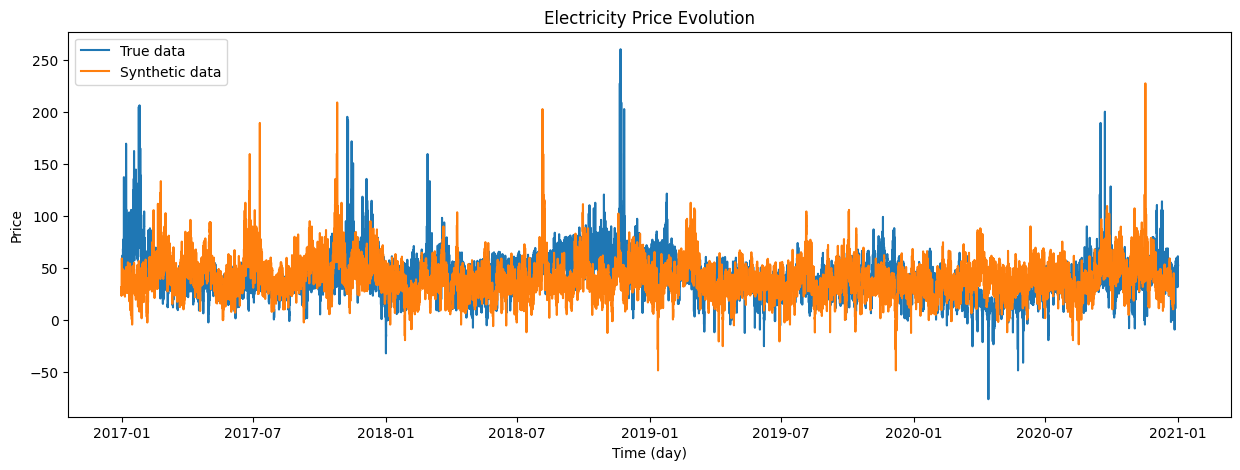

In [6]:
plot_prices([df_price_preprocessed, df_price_generated_00257_preprocessed], ["True data", "Synthetic data"])

## Without data augmentation

In [7]:
n_before = 10
window_size = 12
window_step = min(TESTED_HORIZONS[4], window_size)
horizon = TESTED_HORIZONS[4]
features = ["dayofweek", "hourofday", "dayofmonth", "month", "year", "price"]
test_size = TESTED_HORIZONS[-1] + window_size # to have enough data to predict the last horizon (168 h)
dataset = DatasetWithWindow(df_price_preprocessed, window_size, window_step, horizon, features, "price")
# dataset = DatasetWithWindow(df_price_preprocessed, window_size, window_step, horizon, "price", "price")

# splits
train_split, val_split, test_split = get_splits(dataset, test_size, VAL_RATIO)

predict_dates, predict_y, predict_x = get_predict_data(test_split, n_before=n_before)

datamodule = Datamodule(train_split, val_split, test_split, batch_size=32)

In [8]:
from electricity_price_forecast.model.transformers_model import TransformersModel

def get_best_params(datamodule, horizon, n_trials=50):
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: train_model(
        datamodule,
        horizon,
        lr=trial.suggest_float("lr", 1e-5, 1e-1),
        n_epochs=30,
        n_layers=trial.suggest_int("n_layers", 1, 10),
    )[-1]["val_loss"], n_trials=n_trials)
    return study.best_params


def train_model(datamodule, horizon, early_stopping=False, num_heads=1, lr=0.001, n_epochs=50, n_layers=1, device="cuda"):
    train_dataloader = datamodule.train_dataloader()
    X_batch, _ = next(iter(train_dataloader))
    input_dim = X_batch.shape[-1]
    
    model_params = {
        "input_dim": input_dim,
        "n_layers": n_layers,
        "output_dim": horizon,
        "num_heads": num_heads,
    }
    
    model = TorchLightningModule(TransformersModel, model_params, lr=lr, device=device)
    
    if early_stopping:
        callbacks = [EarlyStopping(monitor="val_loss", mode="min", patience=5, verbose=False)]
    else:
        callbacks = []
        
    if device == "cuda":
        trainer = pl.Trainer(max_epochs=n_epochs, devices=-1, accelerator="cuda", callbacks=callbacks, enable_checkpointing=False, logger=False)
    else:
        trainer = pl.Trainer(max_epochs=n_epochs, callbacks=callbacks, enable_checkpointing=False, logger=False)
    
    trainer.fit(model, datamodule)
            
    return model, {"val_loss": trainer.callback_metrics["val_loss"], "train_loss": trainer.callback_metrics["train_loss"]}

def eval_model(model, dataloader, device="cuda"):
    predictions = []
    ground_truth = []
    model.eval()
    model.to(device)
    
    with torch.no_grad():
        for X, y in tqdm(dataloader):
            y_pred = model(X)
            predictions.append(y_pred)
            ground_truth.append(y)
    
    predictions = torch.cat(predictions).squeeze()
    ground_truth = torch.cat(ground_truth).squeeze()
    return TorchLightningModule.get_test_metrics(predictions, ground_truth)

def predict(model, x, device="cuda"):
    model.eval()
    model.to(device)
    y_pred = None
    
    with torch.no_grad():
        y_pred = model(x)
    
    return y_pred

In [9]:
best_params = get_best_params(datamodule, horizon, n_trials=3)

[I 2025-01-22 19:45:26,515] A new study created in memory with name: no-name-6bc4def6-7a92-441a-919c-aac903a7c3ea
d:\Programs\Anaconda\envs\air_liquide_ai_challenge\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

d:\Programs\Anaconda\envs\air_liquide_ai_challenge\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


d:\Programs\Anaconda\envs\air_liquide_ai_challenge\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 29: 100%|██████████| 69/69 [00:01<00:00, 35.41it/s, train_loss=5.850, val_loss=11.30]

[I 2025-01-22 19:46:22,681] Trial 0 finished with value: 11.293374061584473 and parameters: {'lr': 0.08914550925407072, 'n_layers': 4}. Best is trial 0 with value: 11.293374061584473.



Epoch 29: 100%|██████████| 69/69 [00:01<00:00, 42.11it/s, train_loss=9.100, val_loss=15.60]

[I 2025-01-22 19:47:15,399] Trial 1 finished with value: 15.579219818115234 and parameters: {'lr': 0.017245589223618185, 'n_layers': 4}. Best is trial 0 with value: 11.293374061584473.



Epoch 29: 100%|██████████| 69/69 [00:01<00:00, 51.55it/s, train_loss=5.870, val_loss=11.90]

[I 2025-01-22 19:47:58,221] Trial 2 finished with value: 11.886126518249512 and parameters: {'lr': 0.08315168268602277, 'n_layers': 3}. Best is trial 0 with value: 11.293374061584473.


In [10]:
best_params

{'lr': 0.08914550925407072, 'n_layers': 4}

In [11]:
model, _ = train_model(datamodule, horizon, n_epochs=20, early_stopping=True, **best_params)

Epoch 5: 100%|██████████| 69/69 [00:01<00:00, 37.53it/s, train_loss=8.890, val_loss=11.10]


100%|██████████| 6/6 [00:00<00:00, 144.50it/s]


Results: {'mse': 465.1817321777344, 'mae': 17.788217544555664, 'rmse': 21.568071365356445}
22 94 73


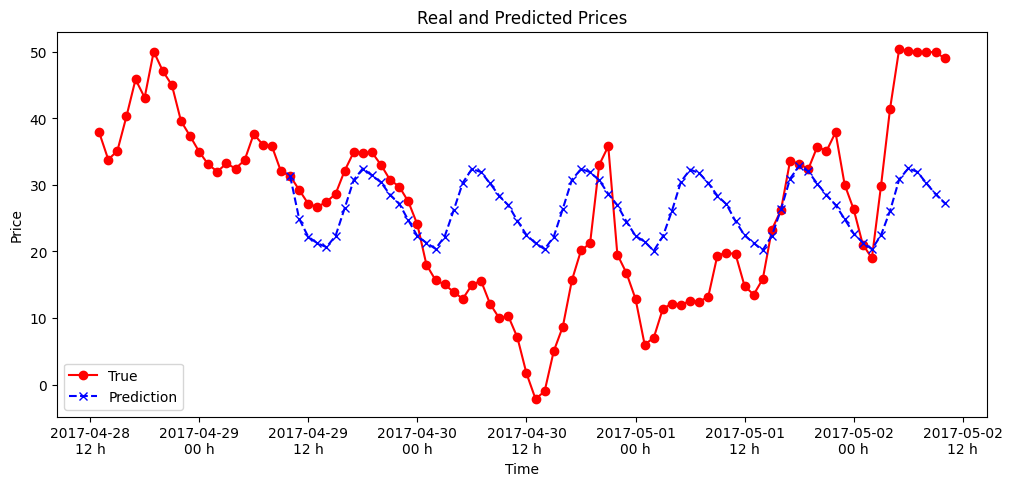

In [12]:
test_dataloader = datamodule.test_dataloader()
results = eval_model(model, test_dataloader)
print("Results:", results)

# add dim before for batch for x[:n_before] for the batch
predictions = predict(model, predict_x.unsqueeze(0), device="cuda")
# take last window ([-1, :])
predictions = predictions.cpu().numpy()[-1, :]

plot_predictions_vs_real(predict_dates, predict_y, predictions)

## With provided data augmentation (synthetic data)

In [13]:
def load_synthetic_datasets(path, window_size, window_step, horizon, max_num_fetched=None):
    if max_num_fetched is not None and max_num_fetched < 0:
        max_num_fetched = None
    train_all = []
    
    i = 0
    for filename in tqdm(os.listdir(path)):
        if max_num_fetched is not None and i >= max_num_fetched:
            break
        i += 1
        if filename.endswith(".parquet"):
            df = pd.read_parquet(path + filename)
            df_preprocessed = preprocess_synthetic_data(df)
            train_all.append(DatasetWithWindow(df_preprocessed, window_size, window_step, horizon, ["dayofweek", "hourofday", "dayofmonth", "month", "year", "price"], "price"))
    
    return train_all

In [14]:
directory = "../data/scenarios synthetiques/prix/"
train_all = load_synthetic_datasets(directory, window_size, window_step, horizon, 3)

  2%|▏         | 3/154 [00:00<00:02, 60.04it/s]


In [15]:
train_concat = ConcatDataset(train_all)

train_split_size = int(len(train_concat)*(1-VAL_RATIO))
val_split_size = len(train_concat) - train_split_size

train_split, val_split, _ = get_splits(train_concat, 0, VAL_RATIO)

predict_dates, predict_y, predict_x = get_predict_data(test_split, n_before=10)

# test_split is the same (we don't want to test on synthetic data)

datamodule = Datamodule(train_split, val_split, test_split, batch_size=32)

#### Find best params

In [16]:
# best_params = get_best_params(datamodule, horizon, n_trials=20)

In [17]:
# best_params = {'lr': 0.08914550925407072, 'n_layers': 4}
best_params

{'lr': 0.08914550925407072, 'n_layers': 4}

In [18]:
model, _ = train_model(datamodule, horizon, n_epochs=20, early_stopping=True, **best_params)

d:\Programs\Anaconda\envs\air_liquide_ai_challenge\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


d:\Programs\Anaconda\envs\air_liquide_ai_challenge\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
d:\Programs\Anaconda\envs\air_liquide_ai_challenge\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 5: 100%|██████████| 218/218 [00:05<00:00, 43.13it/s, train_loss=10.20, val_loss=11.90]


100%|██████████| 6/6 [00:00<00:00, 139.88it/s]

Results: {'mse': 231.9351806640625, 'mae': 10.566739082336426, 'rmse': 15.22941780090332}
22 94 73


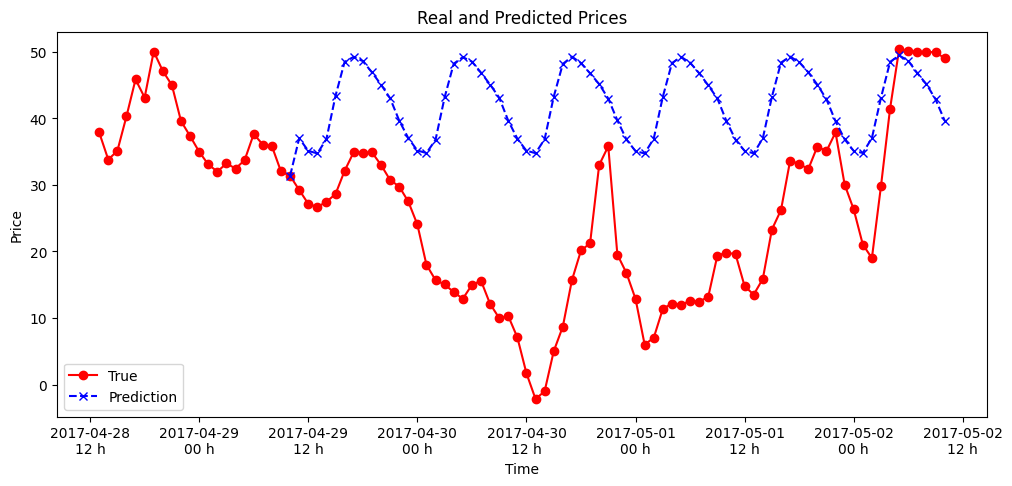

In [19]:
test_dataloader = datamodule.test_dataloader()
results = eval_model(model, test_dataloader)
print("Results:", results)

# add dim before for batch for x[:n_before] for the batch
predictions = predict(model, predict_x.unsqueeze(0), device="cuda")
# take last window ([-1, :])
predictions = predictions.cpu().numpy()[-1, :]

plot_predictions_vs_real(predict_dates, predict_y, predictions)

## With Normalization

In [20]:
data_normalizer = DataNormalizer()
df_price_preprocessed_normalized = data_normalizer.transform_df(df_price_preprocessed)
df_price_preprocessed_normalized.head()

,price,dayofweek,hourofday,dayofyear,dayofseries,dayofmonth,month,year,hourofseries
date,,,,,,,,,
2016-12-31 23:00:00+00:00,0.400989,0.833333,1.000000,1.0,0.000000,1.0,1.0,0.00,0.000000
2017-01-01 00:00:00+00:00,0.399232,1.000000,0.000000,0.0,0.000684,0.0,0.0,0.25,0.000029
2017-01-01 01:00:00+00:00,0.380528,1.000000,0.043478,0.0,0.000684,0.0,0.0,0.25,0.000057
2017-01-01 02:00:00+00:00,0.366590,1.000000,0.086957,0.0,0.000684,0.0,0.0,0.25,0.000086
2017-01-01 03:00:00+00:00,0.361289,1.000000,0.130435,0.0,0.000684,0.0,0.0,0.25,0.000114


In [21]:
test_size = TESTED_HORIZONS[-1] + window_size # to have enough data to predict the last horizon (168 h)
dataset = DatasetWithWindow(df_price_preprocessed_normalized, window_size, window_step, horizon, ["dayofweek", "hourofday", "dayofmonth", "month", "year", "price"], "price")
# dataset = DatasetWithWindow(df_price_preprocessed, window_size, window_step, horizon, "price", "price")

train_split, val_split, test_split = get_splits(dataset, test_size, VAL_RATIO)
predict_dates, predict_y, predict_x = get_predict_data(test_split, n_before=10)

datamodule = Datamodule(train_split, val_split, test_split, batch_size=32)

In [22]:
best_params = get_best_params(datamodule, horizon, n_trials=3)

[I 2025-01-22 19:48:43,300] A new study created in memory with name: no-name-9a0c2bf8-03aa-40f8-a537-f46865d7dd56
d:\Programs\Anaconda\envs\air_liquide_ai_challenge\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Sanity Checking:   0%|          | 0/2 [00:00<?, ?it/s]

d:\Programs\Anaconda\envs\air_liquide_ai_challenge\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


d:\Programs\Anaconda\envs\air_liquide_ai_challenge\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 29: 100%|██████████| 69/69 [00:02<00:00, 27.97it/s, train_loss=0.0339, val_loss=0.0395]

[I 2025-01-22 19:49:58,713] Trial 0 finished with value: 0.03945121169090271 and parameters: {'lr': 0.04016963835331307, 'n_layers': 6}. Best is trial 0 with value: 0.03945121169090271.



Epoch 29: 100%|██████████| 69/69 [00:03<00:00, 20.69it/s, train_loss=0.0355, val_loss=0.0475]

[I 2025-01-22 19:51:44,375] Trial 1 finished with value: 0.04753271862864494 and parameters: {'lr': 0.081458800334918, 'n_layers': 9}. Best is trial 0 with value: 0.03945121169090271.



Epoch 29: 100%|██████████| 69/69 [00:02<00:00, 28.13it/s, train_loss=0.033, val_loss=0.044]  

[I 2025-01-22 19:52:55,052] Trial 2 finished with value: 0.04404773563146591 and parameters: {'lr': 0.09895062240388458, 'n_layers': 6}. Best is trial 0 with value: 0.03945121169090271.


In [23]:
# best_params = {'lr': 0.04016963835331307, 'n_layers': 6}
best_params

{'lr': 0.04016963835331307, 'n_layers': 6}

In [24]:
model, _ = train_model(datamodule, horizon, n_epochs=20, early_stopping=True, **best_params)

Epoch 13: 100%|██████████| 69/69 [00:02<00:00, 29.66it/s, train_loss=0.0407, val_loss=0.0549]


  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 110.19it/s]

Results: {'mse': 0.0023133542854338884, 'mae': 0.034489355981349945, 'rmse': 0.04809734225273132}
22 94 73


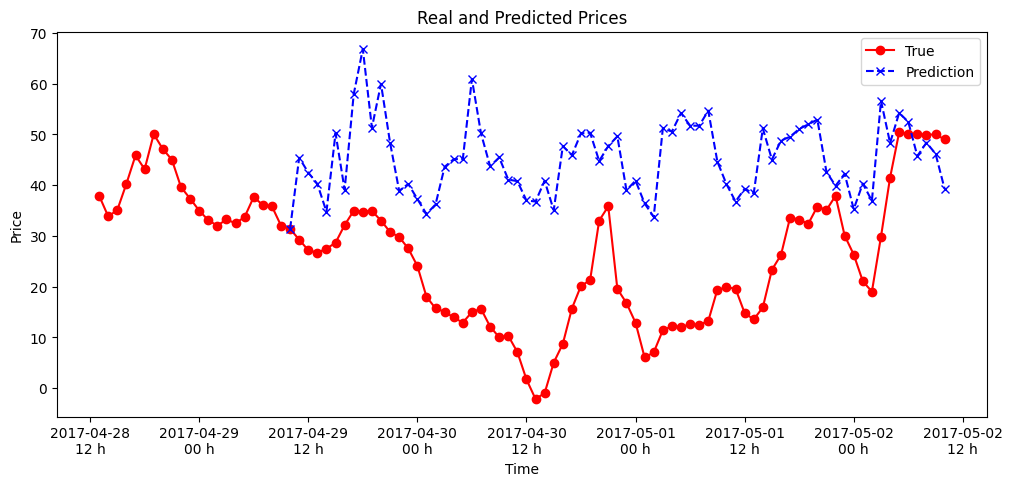

In [25]:
test_dataloader = datamodule.test_dataloader()
results = eval_model(model, test_dataloader)
print("Results:", results)

# add dim before for batch for x[:n_before] for the batch
predictions = predict(model, predict_x.unsqueeze(0), device="cuda")
# take last window ([-1, :])
predictions = predictions.cpu().numpy()[-1, :]

plot_predictions_vs_real(predict_dates, predict_y, predictions, data_normalizer)